In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import glob

import h5py
import flammkuchen as fl
import seaborn as sns
from matplotlib.cm import ScalarMappable
import scipy
from scipy import stats

In [3]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats

In [4]:
from megabouts_helper import labels_cat, color, color_bouts, cmp_bouts, color_ipsi_cont
from preprocess_helper import simplify_fish_id

In [5]:
save_figure_path = Path(r'\\portulab.synology.me\data\Kata\Figures_Paper\Figure_2\supp\suppl_5')

In [6]:
master_path = Path(r'\\portulab.synology.me\data\Kata\Processed_Data\tensor_data')
path_tensors = Path(r'\\portulab.synology.me\data\Kata\Processed_Data\tensor_data\tensors\tensor.h5')
path_features = Path(r'\\portulab.synology.me\data\Kata\Processed_Data\tensor_data\features_bouts_new.csv')
master_path, path_features

(WindowsPath('//portulab.synology.me/data/Kata/Processed_Data/tensor_data'),
 WindowsPath('//portulab.synology.me/data/Kata/Processed_Data/tensor_data/features_bouts_new.csv'))

In [7]:
### tail, fin 1, fin 2, left eye, right eye

traces =  fl.load(path_tensors)
traces.shape

(11063, 3, 50)

In [8]:
tail = traces[:, 0, :]

fin_1 = traces[:, 1, :] #*-1
fin_2 = traces[:, 2, :]


In [9]:
## lets remove baseline from left and right fin
for trial in range(fin_1.shape[0]):
    fin_1[trial,:] = fin_1[trial, :] - fin_1[trial,0]
    fin_2[trial,:] = fin_2[trial, :] - fin_2[trial,0]

### read in features

In [10]:
features = pd.read_csv(path_features)
features.head()

,Unnamed: 0,exp,fish_id,bout_angle,cluster,frame_start,frame_end,bout_id_orig,mb_proba,max_eye_rot,...,tail_freq,l_fin_freqs,r_fin_freqs,tail_max_freq,l_fin_max_freqs,r_fin_max_freqs,l_start,l_end,r_start,r_end
0,0,13052024_visstim_2D_round,240513_f0,3.000171,0,18375,18410,78,0.806645,-0.239648,...,0.121622,0.105263,0.109756,0.166667,0.166667,0.166667,0.0,27.0,0.0,28.0
1,1,13052024_visstim_2D_round,240513_f0,1.649302,0,19461,19484,80,1.000000,0.479035,...,0.058140,0.117647,0.119048,0.166667,0.166667,0.250000,0.0,15.0,7.0,26.0
2,2,13052024_visstim_2D_round,240513_f0,-0.861132,0,19661,19689,81,1.000000,-1.120168,...,0.097561,0.115385,0.104167,0.166667,0.166667,0.125000,4.0,20.0,0.0,27.0
3,3,13052024_visstim_2D_round,240513_f0,0.870591,0,20257,20292,84,1.000000,-2.662451,...,0.114286,0.117647,0.117647,0.166667,0.166667,0.125000,19.0,35.0,0.0,35.0
4,4,13052024_visstim_2D_round,240513_f0,2.231631,0,20824,20859,86,1.000000,-1.192489,...,0.108108,0.116667,0.103448,0.166667,0.125000,0.125000,0.0,23.0,6.0,28.0


In [11]:
# Apply the function to the 'fish_ids' column
features['fish_id'] = features['fish_id'].apply(simplify_fish_id)

In [12]:
fish_ids = np.unique(features['fish_id'])
len(fish_ids)

64

In [13]:
clusters = features.cluster.astype(int)

In [14]:
alph=0.5
size=1
cm_ = 1/2.54  # centimeters in inches
f_size =6
contrast = 2.2 # Contrast control ( 0 to 127)
brightness = 0.01 # Brightness control (0-100)
lw=0.5
dpi= 600

### Looking at forward fins only 

    Do fish have a prefered fin?

    In order to determine if there's an effect of fish_id on lf (when lf is either 0 or 1), you would typically perform a statistical analysis.

    One common approach would be to use an ANOVA (Analysis of Variance) if lf is a continuous variable or a chi-square test if lf is a categorical variable.
    This could help you determine if there are significant differences in the lf values across the different fish_ids.

### over all forward bouts

In [15]:
# Assuming 'features' is your DataFrame and 'clust' is a list of cluster values you want to include
clust_values = [0, 1, 2, 3]  # Replace with your actual cluster values
fish_ids = features[features['cluster'].isin(clust_values)]['fish_id'].values
lf = features[features['cluster'].isin(clust_values)]['leading_fin'].values
bout_angle = features[features['cluster'].isin(clust_values)]['bout_angle'].values
clust = features[features['cluster'].isin(clust_values)]['cluster'].values
bout_angle.shape

(5124,)

In [16]:
# Create a dataframe from your data:
data = pd.DataFrame({'fish_id': fish_ids, 'lf': lf, 'bout_angle':bout_angle, 'cluster': clust})
# Select only the rows where lf is 0 or 1:
data = data[data['lf'].isin([0, 1])]
print (data.shape, np.unique(data.cluster))
data.head()

(4904, 4) [0 1 2 3]


,fish_id,lf,bout_angle,cluster
0,240513_f0,1,3.000171,0
1,240513_f0,0,1.649302,0
2,240513_f0,1,-0.861132,0
3,240513_f0,1,0.870591,0
4,240513_f0,0,2.231631,0


### handedness index

In [17]:
# First, you need to group your data by 'fish_Id' and 'lf' 
grouped = data.groupby(['fish_id', 'lf']).size()

# Then, for each fish_Id, you calculate the index
def calculate_index(group):
    count_0 = group.get(0, 0)  # get the count for 0, and if not present, assume it to be 0
    count_1 = group.get(1, 0)  # same for 1
    total_counts = count_0 + count_1
    if total_counts > 0:
        if count_0 == total_counts:
            return -1  # only right fin used
        elif count_1 == total_counts:
            return 1  # only left fin used
        else:
            return (count_1 - count_0) / total_counts  # both fins used
    else:
        return 0  # no fins used

index = grouped.groupby(level=0).apply(calculate_index)

# 'index' now contains the calculated index for each fish_Id
df_laterality = pd.DataFrame({'fish_id':index.index, 'laterality_score':index.values})
df_laterality.reset_index(drop=True, inplace=True)
df_laterality.head()


,fish_id,laterality_score
0,110659_f0,-0.200000
1,111701_f0,-1.000000
2,112901_f1,0.400000
3,113916_f2,0.277108
4,114946_f2,0.254237


In [18]:
lat = df_laterality.laterality_score.values

In [19]:
### now lets get left and right handed fish in upper quantiles
# assuming 'data' is your DataFrame and 'calculate_index' is your function to calculate the index

# Calculate quantiles
upper_quantile = np.percentile(lat, 75)
lower_quantile = np.percentile(lat, 25)
print (lower_quantile, upper_quantile)

# Segment fish into two groups
prefer_right = index[lat > upper_quantile].index
prefer_left = index[lat < lower_quantile].index

# Print the fish Ids
print("Fish that prefer left: ", prefer_left)
print("Fish that prefer right: ", prefer_right)

# Identify fish that don't have a preference
no_preference = index[(index > lower_quantile) & (index < upper_quantile)].index

# Print the fish Ids
print("Fish that don't show a preference: ", no_preference)


-0.18333333333333335 0.14325955734406437
Fish that prefer left:  Index(['110659_f0', '111701_f0', '120328_f3', '240422_f11', '240422_f12',
       '240422_f3', '240422_f4', '240422_f9', '240424_f6', '240424_f7',
       '240513_f0', '240513_f2', '240513_f6', '240514_f3', '240514_f5',
       '240514_f6'],
      dtype='object', name='fish_id')
Fish that prefer right:  Index(['112901_f1', '113916_f2', '114946_f2', '132040_f6', '240422_f1',
       '240422_f5', '240423_f5', '240423_f6', '240424_f10', '240424_f2',
       '240424_f4', '240513_f10', '240513_f5', '240513_f7', '240514_f0',
       '240514_f1'],
      dtype='object', name='fish_id')
Fish that don't show a preference:  Index(['120350_f3', '123953_f4', '125639_f5', '130839_f5', '133118_f6',
       '240422_f0', '240422_f10', '240422_f13', '240422_f2', '240422_f6',
       '240422_f7', '240422_f8', '240423_f0', '240423_f2', '240423_f3',
       '240423_f4', '240423_f7', '240423_f8', '240424_f0', '240424_f3',
       '240424_f5', '240424_f8

In [20]:
alph=0.5
size=1
cm_ = 1/2.54  # centimeters in inches
f_size =6
contrast = 2.2 # Contrast control ( 0 to 127)
brightness = 0.01 # Brightness control (0-100)
lw=0.5
dpi= 600

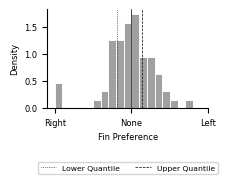

In [53]:

plt.figure(figsize=(6*cm_,6*cm_), facecolor='None')
sns.histplot(data=df_laterality.laterality_score ,color='gray', edgecolor='w', stat='density', bins=np.arange(-1,1,0.1))
plt.axvline(0, ls='-',c='k', lw=lw)
plt.axvline(lower_quantile, ls=':',c='k', label='Lower Quantile', lw=lw)
plt.axvline(upper_quantile, ls='--',c='k', label='Upper Quantile', lw=lw)
plt.xlabel(' ')
plt.ylabel('Density', fontsize=f_size)
plt.tick_params(axis='both', which='major', labelsize=f_size)
plt.legend(fontsize=f_size)  # Add legend to the first subplot
plt.yticks([0, 0.5, 1, 1.5],  fontsize=f_size)
plt.xticks([-1,0, 1], labels=['Right', 'None', 'Left'], fontsize=f_size)
plt.xlabel('Fin Preference', fontsize=f_size)
plt.legend(fontsize=f_size-0.5, loc='upper center', bbox_to_anchor=(0.5,-0.5), ncol=2)

plt.tight_layout()
sns.despine(top=True, right=True, left=False, bottom=False)

plt.savefig(save_figure_path/ 'laterality_hist.pdf', dpi=dpi)
plt.savefig(save_figure_path/ 'laterality_hist.png', dpi=dpi)

### Sort fish accroding to preference

In [23]:
lat_ = df_laterality.laterality_score.values

In [24]:
# Convert the Index objects to lists
prefer_right_list = list(prefer_right)
prefer_left_list = list(prefer_left)

# Remove the misclassified fish IDs from prefer_left
# prefer_left_list.remove('240422_f11')
prefer_left_list.remove('240422_f12')
# prefer_left_list.remove('240513_f9')

# Add the misclassified fish IDs to prefer_right
prefer_right_list.extend(['240422_f11', '240422_f12', '240513_f9'])

# Optionally, convert back to an Index if needed
# prefer_right = pd.Index(prefer_right_list)
# prefer_left = pd.Index(prefer_left_list)

print(prefer_right_list)
print(prefer_left_list)


['112901_f1', '113916_f2', '114946_f2', '132040_f6', '240422_f1', '240422_f5', '240423_f5', '240423_f6', '240424_f10', '240424_f2', '240424_f4', '240513_f10', '240513_f5', '240513_f7', '240514_f0', '240514_f1', '240422_f11', '240422_f12', '240513_f9']
['110659_f0', '111701_f0', '120328_f3', '240422_f11', '240422_f3', '240422_f4', '240422_f9', '240424_f6', '240424_f7', '240513_f0', '240513_f2', '240513_f6', '240514_f3', '240514_f5', '240514_f6']


In [30]:
import matplotlib.patches as mpatches

<Figure size 640x480 with 0 Axes>

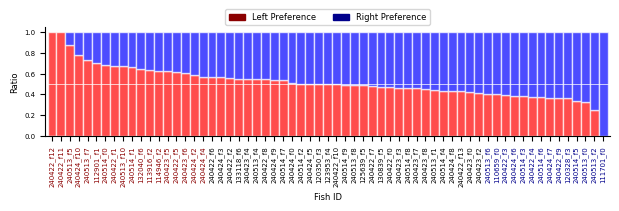

In [52]:
# Calculate ratios
ratios = data.groupby('fish_id')['lf'].value_counts(normalize=True).unstack()

#  If lat_ is an array, add it to the DataFrame as a new column
ratios['lat_index'] = lat_  # Make sure lat_ is aligned with ratios
# Now sort using this new column
ratios = ratios.sort_values(by='lat_index', ascending=False)
ratios = ratios.drop(columns='lat_index')
# Move the third-to-last (-3) to the second-to-last (-1) elements to the front
ratios = pd.concat([ratios.iloc[-3:-1], ratios.iloc[:-3], ratios.iloc[-1:]])

# Plot
# Assuming ratios is your DataFrame
# Swap the order of columns if it's a two-column DataFrame
# If 'lf' represents the columns, you would normally have something like:
# ratios = ratios[['left', 'right']] # Original order
ratios = ratios[ratios.columns[::-1]]  # This will reverse the order of columns

# Plot
plt.figure(facecolor='None')

# Adjust the colors to match the flipped data
ratios.plot(kind='bar', width=1, stacked=True, color=['red', 'blue'], edgecolor='w', alpha=0.7, figsize=(16*cm_, 6*cm_))
plt.ylabel('Ratio', fontsize=f_size)
plt.xlabel('Fish ID', fontsize=f_size)
plt.xticks(rotation=90)

# Define your custom colors for the legend
legend_colors = ['darkred', 'darkblue']

# Create legend handles with the desired colors
left_pref_patch = mpatches.Patch(color=legend_colors[0], label='Left Preference')
right_pref_patch = mpatches.Patch(color=legend_colors[1], label='Right Preference')

plt.legend(handles=[left_pref_patch, right_pref_patch],loc='upper center', bbox_to_anchor=(0.5,1.2), ncol=2, fontsize=f_size)
sns.despine(top=True, right=True, left=True, bottom=True, offset=None, trim=False)
plt.axhline(0.5, c='w', lw=lw)

# Change xtick label colors
ax = plt.gca()  # Get current axis
for label in ax.get_xticklabels():
    fish_id = label.get_text()
    if fish_id in prefer_right_list:
        label.set_color('darkred')
    elif fish_id in prefer_left_list:
        label.set_color('darkblue')
        

plt.tick_params(axis='both', which='major', labelsize=f_size-1)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.tight_layout()
plt.savefig(save_figure_path /'leading_fin_fish_id_ratio.pdf', dpi=dpi)
plt.savefig(save_figure_path /'leading_fin_fish_id_ratio.png', dpi=dpi)

In [39]:
# Create DataFrames for each group
df_prefers_left = data[data['fish_id'].isin(prefer_left)]
df_prefers_right = data[data['fish_id'].isin(prefer_right)]
# Create DataFrame for fish without a clear preference
df_no_preference = data[data['fish_id'].isin(no_preference)]


In [40]:
df_prefers_left.head()

,fish_id,lf,bout_angle,cluster
0,240513_f0,1,3.000171,0
1,240513_f0,0,1.649302,0
2,240513_f0,1,-0.861132,0
3,240513_f0,1,0.870591,0
4,240513_f0,0,2.231631,0


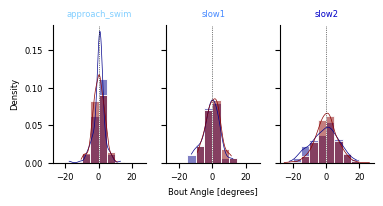

In [41]:
# Assuming df_prefers_left and df_prefers_right are already defined
# and labels_cat and color are defined as well

bins = np.arange(-25, 25, 5)
fig, axes = plt.subplots(1, 3, figsize=(10*cm_,5.5*cm_), facecolor='None', sharex=True, sharey=True)
axes = axes.ravel()

for clust in range(3):
    ax=sns.histplot(
        data=df_prefers_left.bout_angle[df_prefers_left.cluster == clust],
        edgecolor='w',
        color='darkblue',
        kde=True,
        bins=bins,
        label='Right Preference',
        stat='density',  # Normalize histogram
        ax=axes[clust]
    )
    for line in ax.get_lines():    
        line.set_linewidth(lw)  # Set the desired line width here
    ax=sns.histplot(
        data=df_prefers_right.bout_angle[df_prefers_right.cluster == clust],
        edgecolor='w',
        color='darkred',
        kde=True,
        bins=bins,
        label='Left Preference',
        stat='density',  # Normalize histogram
        ax=axes[clust]
    )
    for line in ax.get_lines():    
        line.set_linewidth(lw)  # Set the desired line width here
    axes[clust].axvline(0, c='k', ls=':', lw=lw)
    axes[clust].set_title(labels_cat[clust], color=color[clust], fontsize=f_size)
    axes[clust].set_xlabel(' ', fontsize=f_size)
    
axes[1].set_xlabel('Bout Angle [degrees]', fontsize=f_size)
axes[0].set_ylabel('Density', fontsize=f_size)
axes[0].set_yticks([0, 0.05, 0.1, 0.15])
for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=f_size)
# axes[-1].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=f_size)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.tight_layout()

plt.savefig(save_figure_path / 'preference_bout_cat_bout_angle_fwd_ba.pdf', dpi=dpi)
plt.savefig(save_figure_path / 'preference_bout_cat_bout_angle_fwd_ba.png', dpi=dpi)
